    Authors: XAVIER BELTRAN URBANO

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Enhancing Multiclass Skin Lesion Classification: A Segmentation Step Previous to the Classification Task

# IMPORT LIBRARIES (MODULES)

In [ ]:
# Libraries for exploratory data analysis (EDA)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2 as cv
from PIL import Image
from glob import glob
import random

# Libraries for data preprocessing, augmentation and data generators
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.utils import Sequence


# Libraries for feature extraction and classification using deep learning
import keras
import tensorflow
from keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dropout, Flatten, Dense
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, concatenate, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.resnet import ResNet50
from keras.layers import Activation
from keras import backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array



# Libraries for evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score, roc_curve, confusion_matrix, auc, RocCurveDisplay

import warnings
warnings.filterwarnings("ignore")

## DataGenerator Class

In [ ]:
# -----------------------------------------------------------------------------
# DataGenerator Class
# Author: Xavier Beltran Urbano
# Date Created: 2023-09-20
# -----------------------------------------------------------------------------

class DataGenerator(Sequence):
    """
    Custom data generator for training deep learning models on image segmentation tasks.

    Attributes:
        image_directory (str): Directory containing input images.
        mask_directory (str): Directory containing corresponding segmentation masks.
        list_IDS (list): List of IDs (file names without extensions) for the data samples to include.
        batch_size (int): Size of each batch.
        target_size (tuple): Target size for image and mask resizing.
        data_augmentation (bool): Flag indicating whether to apply data augmentation.
        shuffle (bool): Flag indicating whether to shuffle the data.
    """

    def __init__(self, image_directory, mask_directory, list_IDS, batch_size, target_size, data_augmentation, shuffle=True):
        self.image_directory = image_directory
        self.mask_directory = mask_directory
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.data_augmentation = data_augmentation

        # Get the list of image and mask file names based on the provided IDs
        self.image_filenames = sorted([filename for filename in os.listdir(image_directory) if filename.endswith('.jpg') and filename.split('.')[0] in list_IDS])
        self.mask_filenames = sorted([filename for filename in os.listdir(mask_directory) if filename.replace('_segmentation.png', '') in list_IDS])

        # Calculate the number of batches
        self.num_batches = len(self.image_filenames) // self.batch_size

        # Initialize indices for data shuffling
        self.indices = np.arange(len(self.image_filenames))

        # Shuffle the indices if required
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        """
        Get the number of batches per epoch.
        """
        return self.num_batches

    def __getitem__(self, index):
        """
        Generate a batch of data.

        Args:
            index (int): Index of the batch.

        Returns:
            batch_images (np.ndarray): Batch of preprocessed images.
            batch_masks (np.ndarray): Batch of corresponding masks.
        """
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        batch_image_filenames = [self.image_filenames[i] for i in batch_indices]
        batch_mask_filenames = [self.mask_filenames[i] for i in batch_indices]

        # Load and preprocess batch images and masks
        batch_images = []
        batch_masks = []
        for image_filename, mask_filename in zip(batch_image_filenames, batch_mask_filenames):
            image_path = os.path.join(self.image_directory, image_filename)
            mask_path = os.path.join(self.mask_directory, mask_filename)

            img = load_img(image_path, target_size=self.target_size, color_mode='rgb')
            img = img_to_array(img)
            img = img / 255.0  # Normalize the image to values between 0 and 1

            mask = img_to_array(load_img(mask_path, target_size=self.target_size))
            mask = (mask > 0).astype(np.float32)

            # Data augmentation: Flip images horizontally and/or vertically.
            if self.data_augmentation:
                rand_flip1 = np.random.randint(0, 2)
                rand_flip2 = np.random.randint(0, 2)
                if rand_flip1 == 1:
                    img = np.flip(img, 0)
                    mask = np.flip(mask, 0)
                if rand_flip2 == 1:
                    img = np.flip(img, 1)
                    mask = np.flip(mask, 1)

            batch_images.append(img)
            batch_masks.append(mask)

        batch_images = np.array(batch_images)
        batch_masks = np.array(batch_masks)

        return batch_images, batch_masks

    def on_epoch_end(self):
        """
        Shuffle the data indices at the end of each epoch if required.
        """
        if self.shuffle:
            np.random.shuffle(self.indices)


## DATA PREPARATION

Firstly, we separate the dataset into training, validation and test.

In [ ]:
list_IDS=[filename.split('.')[0]  for filename in os.listdir('/content/drive/MyDrive/ISIC 2017/ISIC-2017_Training_Data') if filename.endswith('.jpg')]
random.shuffle(list_IDS)
# Keep 80% for training, in which 20% is for validation, and 20% for test
num_to_keep = int(0.8 * len(list_IDS))
training = list_IDS[:num_to_keep]
list_IDS_training = list_IDS[:int(num_to_keep*0.8)]
list_IDS_validation = training[int(num_to_keep*0.8):]
list_IDS_test = list_IDS[num_to_keep:]

print(len(list_IDS_training))
print(len(list_IDS_validation))
print(len(list_IDS_test))

1280
320
400


We create the data generators

In [ ]:
train_generator=DataGenerator(
    image_directory='/content/drive/MyDrive/ISIC 2017/ISIC-2017_Training_Data',
    mask_directory='/content/drive/MyDrive/ISIC 2017/ISIC-2017_Training_Part1_GroundTruth',
    list_IDS=list_IDS_training,
    batch_size=32,
    target_size=(224,224),
    data_augmentation=True)

validation_generator=DataGenerator(
    image_directory='/content/drive/MyDrive/ISIC 2017/ISIC-2017_Training_Data',
    mask_directory='/content/drive/MyDrive/ISIC 2017/ISIC-2017_Training_Part1_GroundTruth',
    list_IDS=list_IDS_validation,
    batch_size=32,
    target_size=(224,224),
    data_augmentation=False)

test_generator=DataGenerator(
    image_directory='/content/drive/MyDrive/ISIC 2017/ISIC-2017_Training_Data',
    mask_directory='/content/drive/MyDrive/ISIC 2017/ISIC-2017_Training_Part1_GroundTruth',
    list_IDS=list_IDS_test,
    batch_size=32,
    target_size=(224,224),
    data_augmentation=False)

# BUILD CNN BASED DEEP LEARNING MODEL

We define the metric and loss that we will use for the training of our model.

In [ ]:
def dice_coef(y_true, y_pred, epsilon=0.00001):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf

    """
    axis = (0,1,2)
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true*y_true, axis=axis) + K.sum(y_pred*y_pred, axis=axis) + epsilon
    return K.mean((dice_numerator)/(dice_denominator))

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


We train the pretrained model ResNet50 using the weights of RadImageNet

In [ ]:
weights_path = "/content/drive/MyDrive/ISIC 2017/Pretrained model weights/RadImageNet-ResNet50_notop.h5"
base_model = ResNet50(weights=None, include_top=False, input_shape=(224,224,3))
base_model.load_weights(weights_path)

base_model.trainable = False
for layer in base_model.layers[:-15]: # We only unfreeze the last 15 layers
    layer.trainable = True

# Add an upsampling block
x = base_model.output
x = Conv2DTranspose(1, (32, 32), strides=(32, 32), padding='same')(x)
x = Activation('sigmoid')(x)

# Create the model
model_segmentation = Model(inputs=base_model.input, outputs=x)
model_segmentation.compile(optimizer=Adam(learning_rate=1e-4),loss=dice_coef_loss, metrics=dice_coef)

We show an example of the dataset.

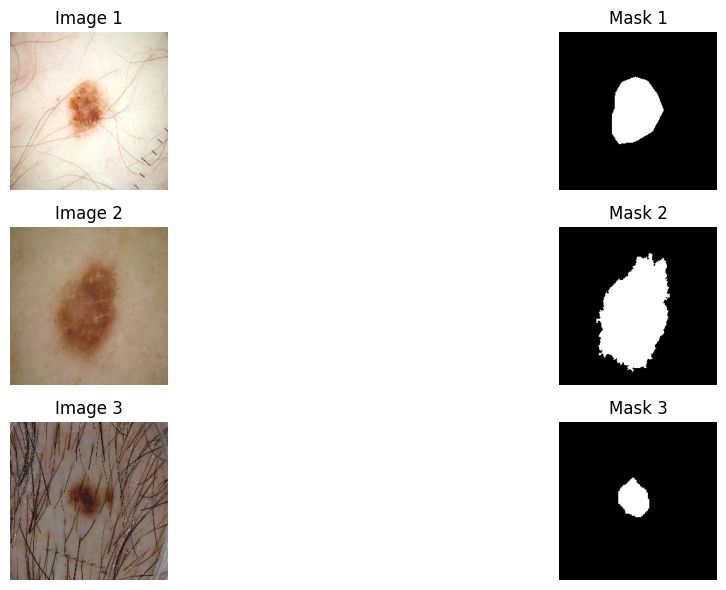

In [ ]:
# Get a batch of data (you can adjust the batch index)
batch_index = 0
batch_images, batch_masks = train_generator[batch_index]

# Create a figure to display multiple examples
plt.figure(figsize=(18, 6))

# Display three random samples from the batch
for i in range(3):
    sample_index = np.random.randint(0, batch_images.shape[0])  # Random sample index
    image = batch_images[sample_index]
    mask = batch_masks[sample_index]

    # Create a single subplot for each example
    plt.subplot(3, 3, i * 3 + 1)
    plt.imshow(image)
    plt.title(f'Image {i+1}')
    plt.axis('off')

    plt.subplot(3, 3, i * 3 + 2)
    plt.imshow(mask.squeeze(), cmap='gray')  # Squeeze removes the single channel dimension
    plt.title(f'Mask {i+1}')
    plt.axis('off')

plt.tight_layout()  # Ensures proper spacing
plt.show()


We train our model.

In [ ]:
epochs = 30
history = model_segmentation.fit(train_generator, validation_data=validation_generator, epochs = epochs, verbose = 1)

Epoch 1/30
40/40 [==============================] - 1223s 29s/step - loss: 0.5258 - dice_coef: 0.4742 - val_loss: 0.4947 - val_dice_coef: 0.5053
Epoch 2/30
40/40 [==============================] - 213s 5s/step - loss: 0.4228 - dice_coef: 0.5772 - val_loss: 0.3901 - val_dice_coef: 0.6099
Epoch 3/30
40/40 [==============================] - 215s 5s/step - loss: 0.2800 - dice_coef: 0.7200 - val_loss: 0.2593 - val_dice_coef: 0.7407
Epoch 4/30
40/40 [==============================] - 223s 6s/step - loss: 0.1775 - dice_coef: 0.8225 - val_loss: 0.1906 - val_dice_coef: 0.8094
Epoch 5/30
40/40 [==============================] - 224s 6s/step - loss: 0.1508 - dice_coef: 0.8492 - val_loss: 0.1516 - val_dice_coef: 0.8484
Epoch 6/30
40/40 [==============================] - 226s 6s/step - loss: 0.1302 - dice_coef: 0.8698 - val_loss: 0.1284 - val_dice_coef: 0.8716
Epoch 7/30
40/40 [==============================] - 223s 6s/step - loss: 0.1190 - dice_coef: 0.8810 - val_loss: 0.1202 - val_dice_coef: 0.87

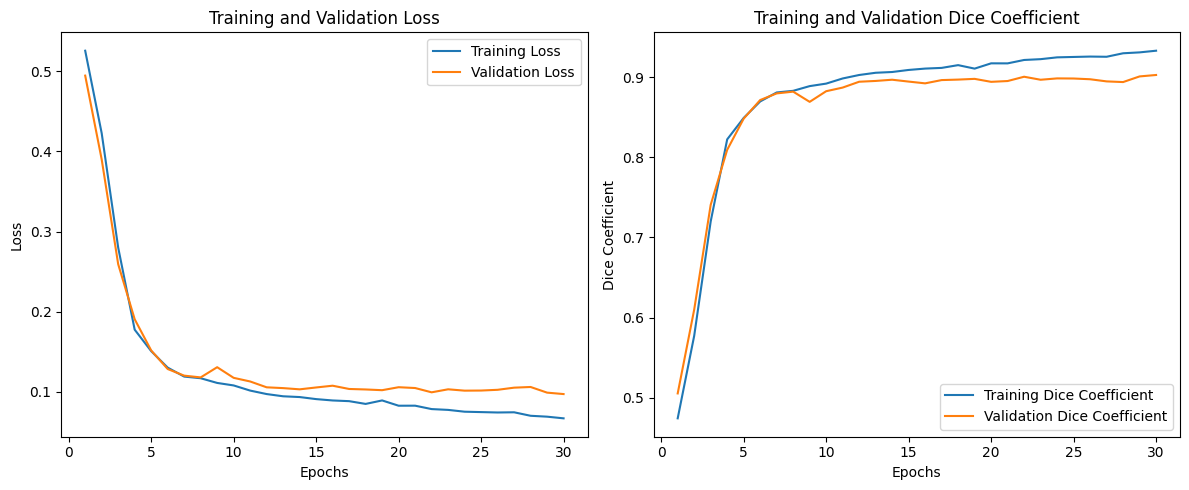

In [ ]:
import matplotlib.pyplot as plt

# Extract loss, Dice coefficient, and validation Dice coefficient history from the 'history' object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_dice_coef = history.history['dice_coef']
val_dice_coef = history.history['val_dice_coef']

# Create subplots for Loss and Dice coefficient
plt.figure(figsize=(12, 5))

# Plot training and validation Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_loss, label='Training Loss')
plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation Dice coefficient
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_dice_coef, label='Training Dice Coefficient')
plt.plot(range(1, epochs+1), val_dice_coef, label='Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.title('Training and Validation Dice Coefficient')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
loss,acc=model_segmentation.evaluate(test_generator,verbose=1)
print(f"Test: Dice= {acc}, Loss= {loss}")

12/12 [==============================] - 275s 25s/step - loss: 0.0885 - dice_coef: 0.9115
Test: Dice= 0.9114711284637451, Loss= 0.0885288417339325


In [ ]:
# Save the trained model to a specific path
model_segmentation.save(f'/content/drive/MyDrive/ISIC 2017/UNET_Models/RESNET50_loss({loss})_dice({acc}).h5')
